<a href="https://colab.research.google.com/github/dksifoua/Object-Detection/blob/master/1%20-%20R-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Load Dependencies

In [ ]:
!pip install tqdm --upgrade

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.50.2)


In [ ]:
import os
import bs4
import cv2
import tqdm
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.3.0


## Download data

In [ ]:
# %%time
# !mkdir -p ./data
# !wget --no-check-certificate \
#     https://data.deepai.org/PASCALVOC2007.zip \
#     -O ./data/pascal-voc-2007.zip
# !unzip -q ./data/pascal-voc-2007.zip -d ./data
# !rm -r ./data/pascal-voc-2007.zip

In [ ]:
TRAIN_VAL_IMAGE_DIR = './data/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/'
TRAIN_VAL_ANNOTATION_DIR = './data/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/Annotations/'

## Parse XML image annotations

In [ ]:
def parse_xml(path):
    contents = open(path).read()
    soup = bs4.BeautifulSoup(contents, 'html.parser')
    filename = soup.find('filename').string
    objects = []
    for obj in soup.find_all('object'):
        objects.append({
            'name': obj.find('name').string,
            'truncated': obj.find('truncated').string,
            'difficult': obj.find('difficult').string,
            'xmin': int(obj.find('xmin').string),
            'ymin': int(obj.find('ymin').string),
            'xmax': int(obj.find('xmax').string),
            'ymax': int(obj.find('ymax').string)
        }) 
    return filename, objects


def get_annotations(path, description=None):
    annotations = {}
    for fn in tqdm.tqdm(os.listdir(path), desc=description):
        filename, objects = parse_xml(os.path.join(path, fn))
        annotations[filename] = objects
    return annotations


train_val_annotations = get_annotations(path=TRAIN_VAL_ANNOTATION_DIR, description='Load train/val annotations')

Load train/val annotations: 100%|██████████| 5011/5011 [00:18<00:00, 272.99it/s]


In [ ]:
LABELS = []
for annotations in train_val_annotations.values():
    for annotation in annotations:
        LABELS.append(annotation['name'])
LABELS = [*set(LABELS)]
print(f'Number of objects: {len(LABELS):,}')
print(LABELS)

Number of objects: 20
['cat', 'boat', 'cow', 'person', 'car', 'bicycle', 'horse', 'bus', 'aeroplane', 'tvmonitor', 'motorbike', 'sheep', 'dog', 'bottle', 'pottedplant', 'chair', 'train', 'bird', 'diningtable', 'sofa']


## Intersection over union

In [ ]:
def compute_intersection_over_union(bndbox1, bndbox2):
    """
    :param dict(int, int, int, int) bndbox1: [x1min, y1min, x1max, y1max]
    :param dict(int, int, int, int) bndbox2: [x2min, y2min, x2max, y2max]
    """
    x1min, y1min, x1max, y1max = bndbox1
    x2min, y2min, x2max, y2max = bndbox2

    w1, w2 = abs(x1min - x1max), abs(x2min - x2max)
    h1, h2 = abs(y1min - y1max), abs(y2min - y2max)

    xmin, xmax = max(x1min, x2min), min(x1max, x2max)
    ymin, ymax = max(y1min, y2min), min(y1max, y2max)
    w, h = max(0, xmax - xmin), max(0, ymax - ymin)

    inter_area = w * h
    union_area = w1 * h1 + w2 * h2 - inter_area

    return inter_area / union_area

## Selective search

CPU times: user 3.2 s, sys: 20.8 ms, total: 3.22 s
Wall time: 2.65 s


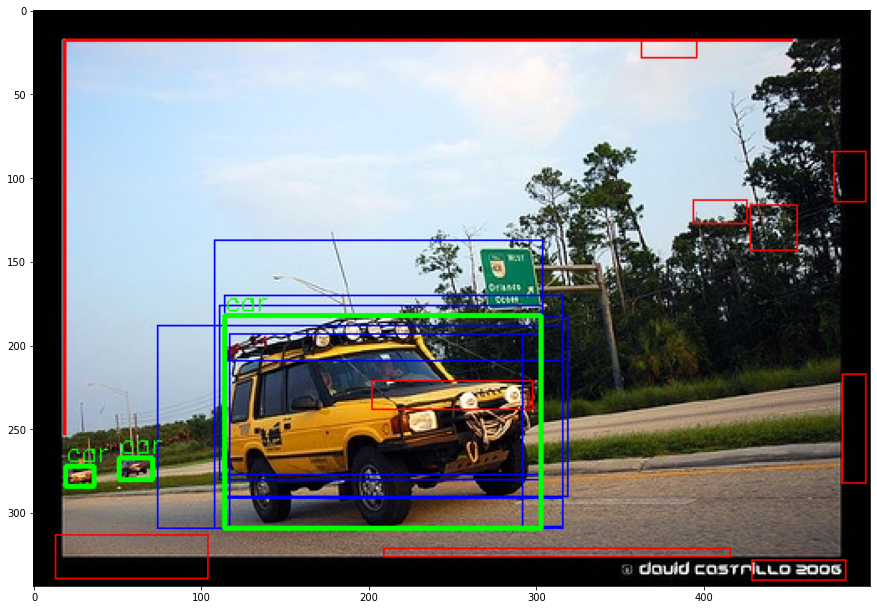

In [ ]:
%%time
MIN_ROI_IOU = 0.7
MAX_IOU = 0.05

image_fn = np.random.choice(os.listdir(TRAIN_VAL_IMAGE_DIR))
image = cv2.imread(os.path.join(TRAIN_VAL_IMAGE_DIR, image_fn))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

annotations = train_val_annotations[image_fn]

selective_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
selective_search.setBaseImage(image)
selective_search.switchToSelectiveSearchFast()
rectangles = selective_search.process()

bndboxes = []
for (x, y, w, h) in rectangles:
    # Convert generated bounding boxes from (x, y, w, h) to (xmin, ymin, xmax, ymax)
    bndboxes.append((x, y, x + w, y + h))

plt.figure(figsize=(15, 15))
count_non_roi = 0
for bndbox in bndboxes:
    prop_xmin, prop_ymin, prop_xmax, prop_ymax = bndbox
    is_not_roi = False
    for annotation in annotations:
        name = annotation['name']
        xmin, ymin = annotation['xmin'], annotation['ymin']
        xmax, ymax = annotation['xmax'], annotation['ymax']
        cv2.putText(image, name, (xmin, ymin - 3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        iou = compute_intersection_over_union(bndbox, (xmin, ymin, xmax, ymax))
        is_not_roi = True if iou < MAX_IOU else False
        if iou > MIN_ROI_IOU:
            cv2.rectangle(image, (prop_xmin, prop_ymin), (prop_xmax, prop_ymax), (0, 0, 255), 1)
    if is_not_roi and count_non_roi <= 10:
        cv2.rectangle(image, (prop_xmin, prop_ymin), (prop_xmax, prop_ymax), (255, 0, 0), 1)
        count_non_roi += 1
plt.imshow(image)

## Create the object detection dataset***

In [ ]:
TRAIN_VAL_OBECT_DETECTION_DATASET_DIR = './data/odd/train_val/'

!rm -rf {TRAIN_VAL_OBECT_DETECTION_DATASET_DIR}
!mkdir -p {TRAIN_VAL_OBECT_DETECTION_DATASET_DIR}

In [17]:
def extract_roi(image_dir, image_annotations, labels, odd_dir, min_roi_iou, max_iou, max_roi_per_annotation_class, max_non_roi_per_image):
    n_images = {name: 0 for name in labels}
    n_images['non_roi'] = 0
    progress_bar = tqdm.tqdm(os.listdir(image_dir))
    for fn in progress_bar:
        image = cv2.imread(os.path.join(image_dir, fn))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        annotations = image_annotations[fn]
        selective_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        selective_search.setBaseImage(image)
        selective_search.switchToSelectiveSearchFast()
        rectangles = selective_search.process()
        bndboxes = []
        for (x, y, w, h) in rectangles:
            bndboxes.append((x, y, x + w, y + h))
        counters = {name: 0 for name in labels}
        counters['non_roi'] = 0
        for bndbox in bndboxes:
            prop_xmin, prop_ymin, prop_xmax, prop_ymax = bndbox
            is_not_roi = False
            for annotation in annotations:
                name = annotation['name']
                xmin, ymin = annotation['xmin'], annotation['ymin']
                xmax, ymax = annotation['xmax'], annotation['ymax']
                iou = compute_intersection_over_union(bndbox, (xmin, ymin, xmax, ymax))
                is_not_roi = True if iou < max_iou else False
                if iou > min_roi_iou and counters[name] <= max_roi_per_annotation_class:
                    roi_path = os.path.join(odd_dir, '{}_{}.jpg'.format(name, n_images[name] + 1))
                    roi = image[prop_ymin:prop_ymax, prop_xmin:prop_xmax]
                    cv2.imwrite(roi_path, roi)
                    counters[name] += 1
                    n_images[name] += 1
                progress_bar.set_description(f'Number of classes with at least 100 roi - {sum([n_images[name] > 100 for name in labels])} / {len(labels)}')
            if is_not_roi and counters['non_roi'] <= max_non_roi_per_image:
                counters['non_roi'] += 1
                non_roi_path = os.path.join(odd_dir, 'non_roi_{}.jpg'.format(n_images['non_roi'] + 1))
                non_roi = image[prop_ymin:prop_ymax, prop_xmin:prop_xmax]
                cv2.imwrite(non_roi_path, non_roi)
        if sum([n_images[name] > 100 for name in labels]) == len(labels):
            print('Got at least 100 region of interest per class.')
            return n_images
    return n_images

In [ ]:
%%time
n_images = extract_roi(image_dir=TRAIN_VAL_IMAGE_DIR, image_annotations=train_val_annotations, labels=LABELS,
                       odd_dir=TRAIN_VAL_OBECT_DETECTION_DATASET_DIR, min_roi_iou=MIN_ROI_IOU, max_iou=MAX_IOU,
                       max_roi_per_annotation_class=5, max_non_roi_per_image=1)